# Generate UMAPs for both QC and no QC datasets (feature selected profiles)

In [1]:
import pathlib
import pandas as pd
import umap
from plotnine import (
    aes,
    element_text,
    facet_wrap,
    geom_point,
    ggplot,
    guide_legend,
    guides,
    labs,
    scale_color_gradient2,
    scale_color_manual,
    theme,
    theme_bw,
)
from plotnine.options import set_option
from pycytominer.cyto_utils import infer_cp_features

In [2]:
# Set constants
umap_random_seed = 0
umap_n_components = 2

# Set embeddings directory
output_dir = pathlib.Path("results")
output_dir.mkdir(parents=True, exist_ok=True)

# Figure directory
figure_dir = pathlib.Path("figures")
figure_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Load in QC and no QC datasets (feature selected profiles)
data_dir = pathlib.Path("../3.preprocessing_profiles/data/single_cell_profiles/")

qc_df = pd.read_parquet(
    data_dir / "CARD-CelIns-CX7_251023130003_sc_feature_selected.parquet"
)
no_qc_df = pd.read_parquet(
    data_dir / "CARD-CelIns-CX7_251023130003_sc_feature_selected_no_QC.parquet"
)

print(f"QC dataset shape: {qc_df.shape}")
print(f"No QC dataset shape: {no_qc_df.shape}")

QC dataset shape: (10849, 1024)
No QC dataset shape: (12158, 1114)


In [4]:
# Add Metadata_QC_status column to the no_QC dataset
no_qc_df["Metadata_QC_status"] = "failed_QC"

# Metadata columns to match
metadata_cols = [
    "Metadata_Plate",
    "Metadata_Well",
    "Metadata_Site",
    "Metadata_Nuclei_Location_Center_X",
    "Metadata_Nuclei_Location_Center_Y",
]

# Mark matching rows as passed_QC
no_qc_df.loc[
    no_qc_df[metadata_cols]
    .apply(tuple, axis=1)
    .isin(qc_df[metadata_cols].apply(tuple, axis=1)),
    "Metadata_QC_status",
] = "passed_QC"

# Print Metadata_QC_status counts
print(no_qc_df["Metadata_QC_status"].value_counts())

Metadata_QC_status
passed_QC    10849
failed_QC     1309
Name: count, dtype: int64


## UMAP for no-QC profile

In [5]:
# Process cp_df to separate features and metadata
cp_features = infer_cp_features(no_qc_df)
meta_features = infer_cp_features(no_qc_df, metadata=True)

# Initialize UMAP instance
umap_fit = umap.UMAP(
    random_state=umap_random_seed, n_components=umap_n_components, n_jobs=1
)

# Fit UMAP and convert to pandas DataFrame
embeddings = pd.DataFrame(
    umap_fit.fit_transform(no_qc_df.loc[:, cp_features]),
    columns=[f"UMAP{x}" for x in range(0, umap_n_components)],
)
print(f"{embeddings.shape} UMAP embeddings generated")

# Combine with metadata
cp_umap_with_metadata_no_qc_df = pd.concat(
    [no_qc_df.loc[:, meta_features], embeddings], axis=1
)

(12158, 2) UMAP embeddings generated


/home/jenna/mambaforge/envs/fibrosis_eda_env/lib/python3.10/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 8 x 8 in image.
/home/jenna/mambaforge/envs/fibrosis_eda_env/lib/python3.10/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: figures/facet_umap_no_QC_plot.png


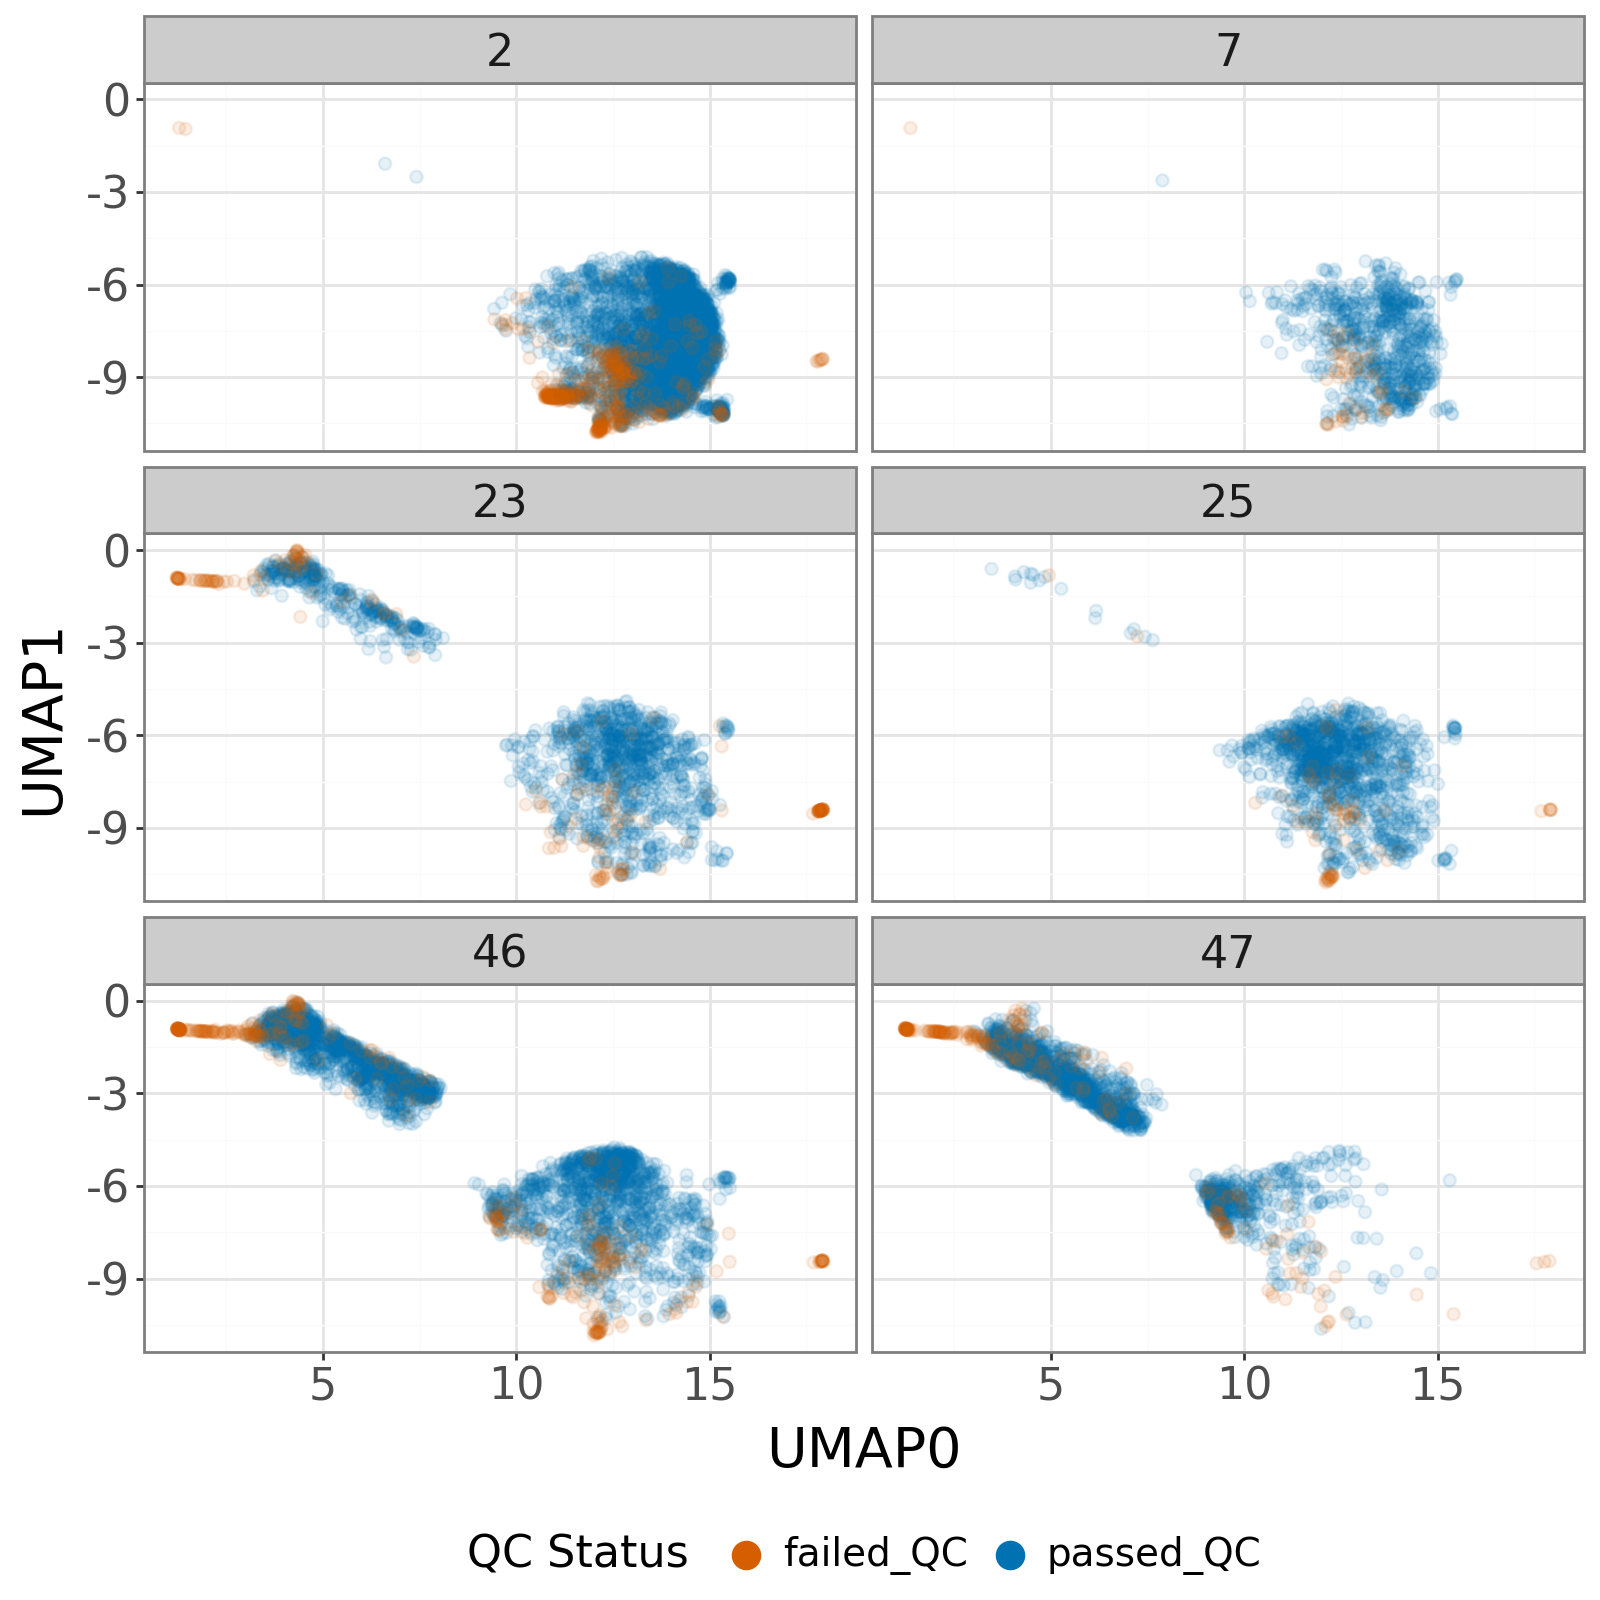

In [6]:
# Reorder so the orange points (failed QC) are plotted on top of blue points (passed QC)
cp_umap_with_metadata_no_qc_df = cp_umap_with_metadata_no_qc_df.sort_values(
    by="Metadata_QC_status", ascending=False
)

# Set the figure size
height = 8
width = 8
set_option("figure_size", (width, height))

# Plot UMAP of non-QC profiles labelled with QC status and
# faceted by treatment and cell type
p = (
    ggplot(
        cp_umap_with_metadata_no_qc_df,
        aes(x="UMAP0", y="UMAP1", color="Metadata_QC_status"),
    )
    + labs(
        color="QC Status",
    )
    + geom_point(alpha=0.1, size=2)
    + facet_wrap(
        "Metadata_heart_number",
        ncol=2,
        scales="fixed",
    )
    + theme_bw()
    + theme(
        axis_title=element_text(size=20),
        axis_text=element_text(size=16),
        legend_title=element_text(size=16),
        legend_text=element_text(size=14),
        legend_position="bottom",
        strip_text=element_text(size=16),  # Adjust facet label size
    )
    + scale_color_manual(
        values={"passed_QC": "#0072B2", "failed_QC": "#D55E00"}
    )  # Blue for passed, orange for failed (colorblind-friendly)
    + guides(
        color=guide_legend(
            override_aes={
                "alpha": 1,  # fully opaque in legend
                "size": 5,  # bigger points in legend
            }
        )
    )
)
# Save the plot
p.save(figure_dir / "facet_umap_no_QC_plot.png", dpi=600, width=width, height=height)

p.show()

## UMAP with QC profiles

In [7]:
# Copy Cells_Intensity_MaxIntensity_Actin and add Metadata_ prefix to use in UMAP plot later
qc_df["Metadata_Cells_Intensity_MaxIntensity_Actin"] = qc_df[
    "Cells_Intensity_MaxIntensity_Actin"
]

# Process cp_df to separate features and metadata
cp_features = infer_cp_features(qc_df)
meta_features = infer_cp_features(qc_df, metadata=True)

# Initialize UMAP instance
umap_fit = umap.UMAP(
    random_state=umap_random_seed, n_components=umap_n_components, n_jobs=1
)

# Fit UMAP and convert to pandas DataFrame
embeddings = pd.DataFrame(
    umap_fit.fit_transform(qc_df.loc[:, cp_features]),
    columns=[f"UMAP{x}" for x in range(0, umap_n_components)],
)
print(f"{embeddings.shape} UMAP embeddings generated")

# Combine with metadata
cp_umap_with_metadata_qc_df = pd.concat(
    [qc_df.loc[:, meta_features], embeddings], axis=1
)

(10849, 2) UMAP embeddings generated


/home/jenna/mambaforge/envs/fibrosis_eda_env/lib/python3.10/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 8 x 8 in image.
/home/jenna/mambaforge/envs/fibrosis_eda_env/lib/python3.10/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: figures/facet_umap_with_QC_plot.png


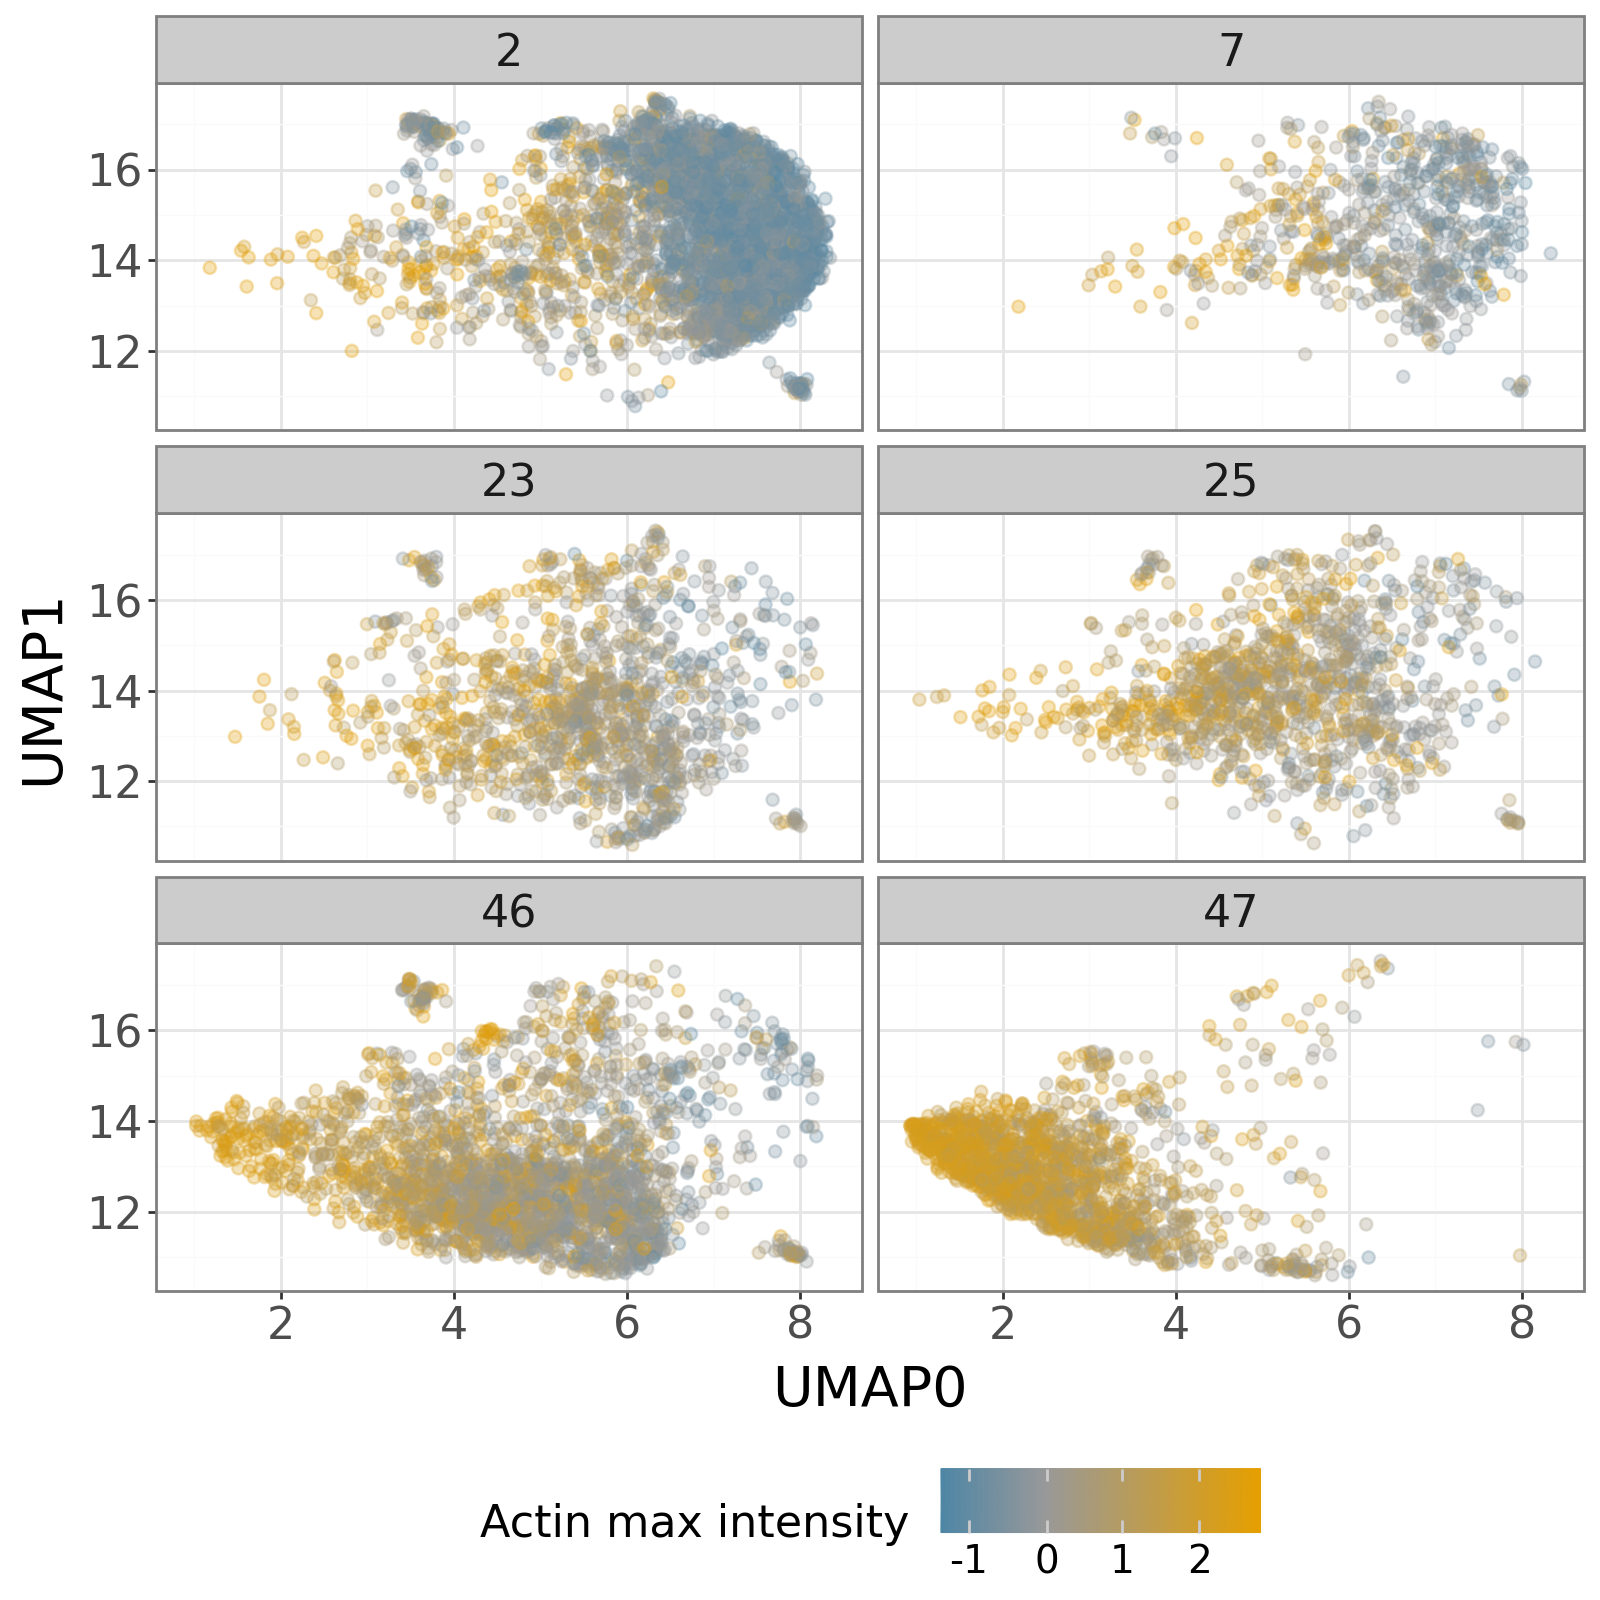

In [8]:
# Set the figure size
height = 8
width = 8
set_option("figure_size", (width, height))

# Plot UMAP of QC profiles colored by actin max intensity and faceted by heart number
p = (
    ggplot(
        cp_umap_with_metadata_qc_df,
        aes(x="UMAP0", y="UMAP1", color="Metadata_Cells_Intensity_MaxIntensity_Actin"),
    )
    + labs(
        color="Actin max intensity",
    )
    + geom_point(alpha=0.3, size=2)
    + facet_wrap(
        "Metadata_heart_number",
        ncol=2,
        scales="fixed",
    )
    + theme_bw()
    + theme(
        axis_title=element_text(size=20),
        axis_text=element_text(size=16),
        legend_title=element_text(size=16),
        legend_text=element_text(size=14),
        legend_position="bottom",
        strip_text=element_text(size=16),
    )
    + scale_color_gradient2(low="#0072B2", mid="#999999", high="#E69F00", midpoint=0)
)
# Save the plot
p.save(figure_dir / "facet_umap_with_QC_plot.png", dpi=600, width=width, height=height)

p.show()

Filtered QC (heart 2) shape: (10849, 47)


/home/jenna/mambaforge/envs/fibrosis_eda_env/lib/python3.10/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 9 x 6 in image.
/home/jenna/mambaforge/envs/fibrosis_eda_env/lib/python3.10/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: figures/facet_umap_qc_heart2_by_treatment.png


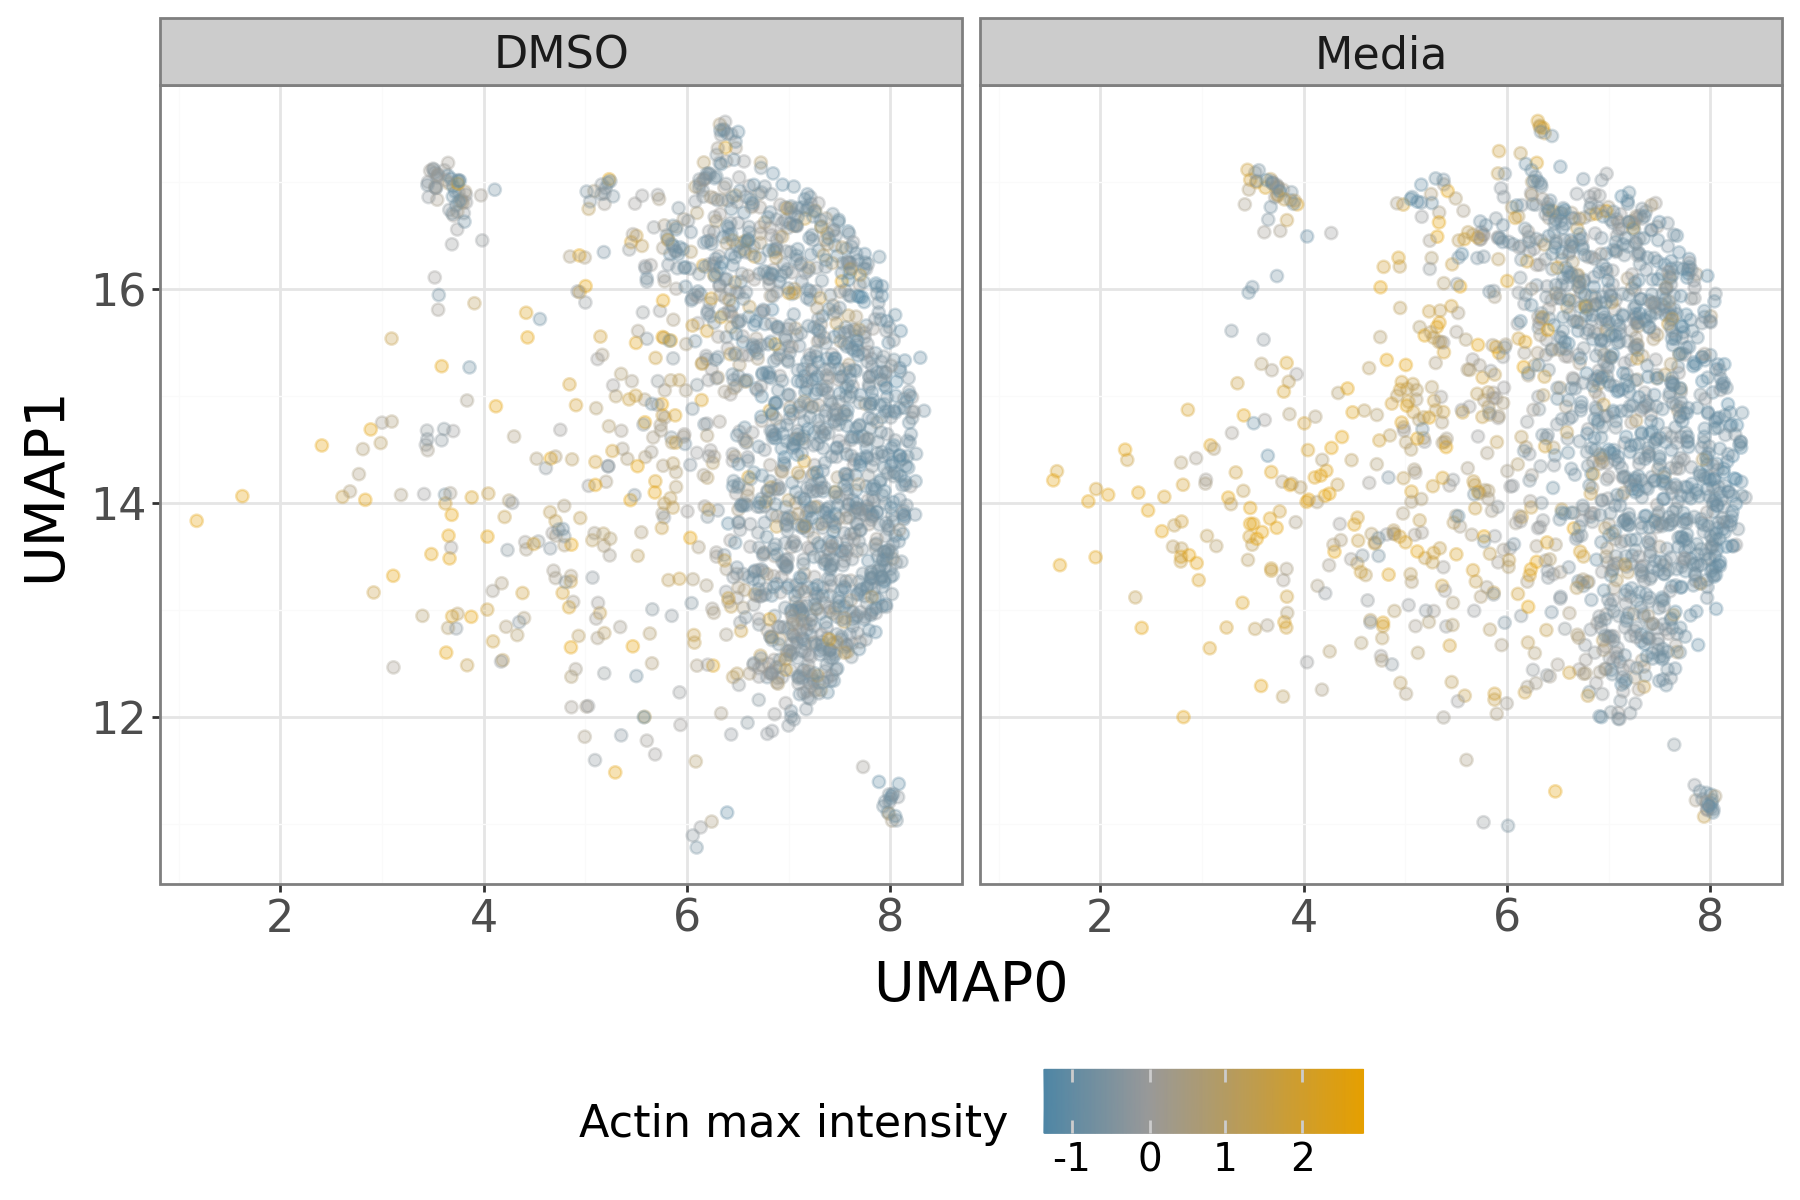

In [9]:
# Filter qc_df to heart #2 and generate the faceted UMAP by Metadata_treatment
cp_umap_with_metadata_qc_h2_df = cp_umap_with_metadata_qc_df[
    qc_df["Metadata_heart_number"] == 2
].copy()
print(f"Filtered QC (heart 2) shape: {cp_umap_with_metadata_qc_df.shape}")

# Change "None" string (not NA) treatment to "Media" for better visualization
cp_umap_with_metadata_qc_h2_df["Metadata_treatment"] = cp_umap_with_metadata_qc_h2_df[
    "Metadata_treatment"
].replace("None", "Media")

# Plot (colored by actin max intensity, faceted by treatment)
width = 9
height = 6
set_option("figure_size", (width, height))
p = (
    ggplot(
        cp_umap_with_metadata_qc_h2_df,
        aes(x="UMAP0", y="UMAP1", color="Metadata_Cells_Intensity_MaxIntensity_Actin"),
    )
    + labs(color="Actin max intensity")
    + geom_point(alpha=0.3, size=2)
    + facet_wrap("Metadata_treatment", ncol=2, scales="fixed")
    + theme_bw()
    + theme(
        axis_title=element_text(size=20),
        axis_text=element_text(size=16),
        legend_title=element_text(size=16),
        legend_text=element_text(size=14),
        legend_position="bottom",
        strip_text=element_text(size=16),
    )
    + scale_color_gradient2(low="#0072B2", mid="#999999", high="#E69F00", midpoint=0)
)

# Save and show
p.save(
    figure_dir / "facet_umap_qc_heart2_by_treatment.png",
    dpi=600,
    width=width,
    height=height,
)
p.show()